# Advanced Leaspy Utilisation

This is already the last practical session of the day ! Be careful you only have an __hour and a half__.

### Objectives :
- Understand data format that is needed to use Leaspy,
- Use Leaspy to perform prediction tasks and evaluate the prediction performances
- Learn how to handle broader classes of data, such as binary observations
- Make links between Leaspy longitudinal parameters and biological cofactors to better understand diseases progressions
- Get a better grasp at the differences between univariate and multivariate models
- Explore models selection

# The set-up

As before, if you have followed the [installation details](https://gitlab.com/icm-institute/aramislab/disease-course-mapping-solutions) carefully, you should

- be running this notebook in the `leaspy_tutorial` virtual environment
- having all the needed packages already installed

<span style='color: #a13203; font-weight: 600;'>💬 Question 1 💬</span> __Run the following command lines.__

In [1]:
!pip install leaspy

In [2]:
!git clone https://gitlab.com/icm-institute/aramislab/disease-course-mapping-solutions.git

Cloning into 'disease-course-mapping-solutions'...
remote: Enumerating objects: 428, done.
remote: Counting objects: 100% (290/290), done.
remote: Compressing objects: 100% (198/198), done.
remote: Total 428 (delta 113), reused 250 (delta 88), pack-reused 138
Receiving objects: 100% (428/428), 52.94 MiB | 327.00 KiB/s, done.
Resolving deltas: 100% (155/155), done.


In [3]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from scipy import stats
%matplotlib inline

sns.set_style('whitegrid')
pd.options.display.float_format = '{:.4g}'.format

from leaspy import Leaspy, IndividualParameters, AlgorithmSettings, Data, __watermark__
from leaspy.io.logs.visualization.plotter import Plotter

data_path = lambda *p: os.path.join('./disease-course-mapping-solutions/challenges/TP3_advanced_leaspy/data', *p)

# Watermark trace with all important packages versions
__watermark__

{'leaspy': '1.2.0',
 'torch': '1.10.1',
 'numpy': '1.21.2',
 'pandas': '1.3.3',
 'scipy': '1.7.3',
 'sklearn': '0.23.1',
 'joblib': '0.16.0',
 'statsmodels': '0.13.0',
 'matplotlib': '3.2.2'}

# Part I: The prediction

One of the main issue of Parkinson disease specialized doctor is that they do not know how fast will the disease evolved and then are unable to set the right spacing between two visits wih their patients. In addition, they would like to give advises to their patients for them to anticipate administrative obligations by the time they are still able to do them. The most important score to monitore is MDS3_off_total, but it is always nice to have a some others.

Leaspy could be a great tool to help solving those issues. The following part contains the main structure to train and test a leaspy model.

### I.1. Prepare your data

<span style='color: #015e75; font-weight: 600;'>ℹ️ Information ℹ️</span> Two datasets, containing 200 patients, are available :
* __learn_leaspy2__ : contains historic data of patients visits,
* __pred_leaspy2__ : contains the next visit for each patient, that it would be nice to predict.

<span style='color: #a13203; font-weight: 600;'>💬 Question 2 💬</span> __Run the following command lines to load the data.__

In [4]:
df = pd.read_csv(data_path("learn_leaspy2.csv"))
df = df.set_index(['ID', 'TIME'], verify_integrity=True).sort_index()
df.head(15)

MDS1_total  MDS2_total  MDS3_off_total  SCOPA_total  MOCA_total  \
ID     TIME                                                                     
GS-001 62.29         NaN       3.556              -9            0       26.78   
       62.79       4.644        6.57           15.66        5.721        25.3   
       63.29       1.956       2.622           29.14            0          30   
       64.29         NaN           0           44.32        44.56       29.85   
       64.79        4.17       4.752           29.65            0       28.53   
       65.29       8.648       1.788           56.67            0        29.7   
       65.79         NaN        9.78           26.18        51.18       28.19   
       66.29       5.156       5.185           18.84        28.73          30   
       66.79       3.011       4.985           29.57            0       28.66   
       66.99         NaN       4.459              -9        61.04          30   
       67.49       4.588       4.187            25.9        32.06       28.85   
       67.99       9.031       2.793           31.62            0       29.53   
       68.99         NaN       10.58           29.08        48.87       28.73   
GS-002 69.35       7.022       9.434           27.54            0       22.74   
       69.55         NaN       8.675           39.12            0       23.57   

              PUTAMEN_R  PUTAMEN_L  CAUDATE_R  CAUDATE_L  AGD_total  
ID     TIME                                                          
GS-001 62.29     0.1687     0.1402    0.06972    0.04153     0.0787  
       62.79     0.1464     0.1721    0.03423    0.08981     0.3749  
       63.29     0.1633     0.1883    0.06959    0.06011     0.1944  
       64.29     0.1857      0.177     0.0534    0.07622     0.2378  
       64.79      0.195     0.1716    0.04802    0.08392     0.1599  
       65.29     0.1708     0.1743    0.08768     0.1094     0.4221  
       65.79     0.1698     0.1904    0.08038    0.09399    0.01398  
       66.29     0.1882     0.1731     0.1012      0.055     0.2324  
       66.79      0.216     0.1666    0.08355      0.116     0.3947  
       66.99     0.1976     0.1914    0.06805    0.09878      0.319  
       67.49     0.1634     0.1602    0.09497    0.09001     0.3499  
       67.99     0.2045     0.1965     0.1215     0.1099     0.3965  
       68.99     0.2259     0.2119      0.127     0.1447     0.4761  
GS-002 69.35     0.2546     0.2134     0.1862     0.1668     0.3906  
       69.55     0.2327     0.2156     0.1898     0.1478      0.411

In [5]:
df_vis = pd.read_csv(data_path("pred_leaspy2.csv"))
df_vis = df_vis.set_index(['ID', 'TIME'], verify_integrity=True).sort_index()
df_vis.head()

,,MDS1_total,MDS2_total,MDS3_off_total,SCOPA_total,MOCA_total,PUTAMEN_R,PUTAMEN_L,CAUDATE_R,CAUDATE_L,AGD_total
ID,TIME,,,,,,,,,,
GS-001,69.09,4.96,5.636,45.67,13.73,27.92,0.2097,0.2294,0.1052,0.1375,0.3196
GS-002,73.65,14.67,9.983,48.46,1.778,19.78,0.2685,0.2116,0.1968,0.1933,0.4046
GS-003,62.49,NaN,9.43,-9,27.02,24.6,0.1825,0.1516,0.0566,0.09603,0.3476
GS-004,67.67,7.17,3.978,7.608,0,27.88,0.2234,0.1852,0.1861,0.1827,0.3129
GS-005,74.13,NaN,3.629,-9,3.493,28.5,0.1979,0.1894,0.114,0.1224,0.337


<span style='color: #015e75; font-weight: 600;'>ℹ️ Information ℹ️</span> You have the following informations about scores :
* __MDS1_total__ : increasing score from 0 to 52,
* __MDS2_total__ : increasing score from 0 to 52,
* __MDS3_off_total__ : increasing score from 0 to 132,
* __SCOPA_total__ : increasing score from 0 to 72,
* __MOCA_total__ : decreasing score from 30 to 0,
* __AGD_total__ : unknown positive score (will need to be explored),
* __Others__ : the rest are imaging increasing score and then have no border, except that they are suppose to be positive.

<span style='color: #a13203; font-weight: 600;'>💬 Question 3 💬</span> __Plot histogram to check that the data are as expected.__

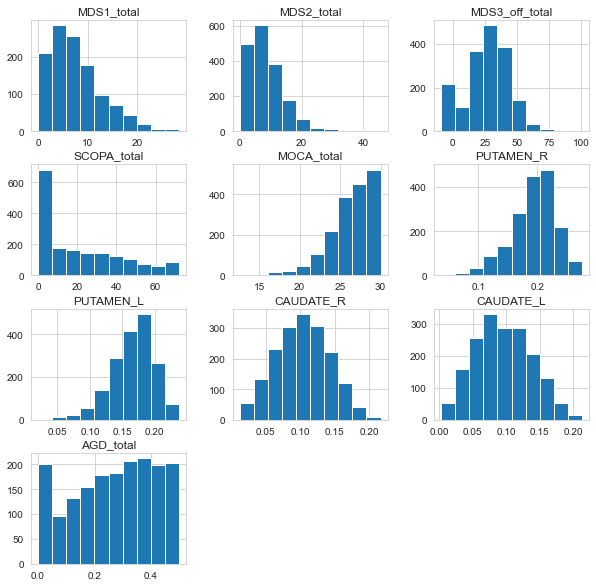

In [6]:
df.hist(figsize = (10,10))
plt.show()

<span style='color: #a13203; font-weight: 600;'>💬 Question 4 💬</span> __Check that the variables respect the constraints. How can you interpret those unexpected datas ?__

Your answer: ...

<span style='color: #a13203; font-weight: 600;'>💬 Question 5 💬</span> __Apply the right pre-processing to those unexpected data. Do not forget to apply it on ALL the data.__

In [7]:
# To inspect values to diagnose issues
df.describe([])
df_vis.describe([])

# To fix issues (nans are coded with -9)
df = df.replace(-9,np.nan)
df_vis = df_vis.replace(-9,np.nan)

<span style='color: #015e75; font-weight: 600;'>ℹ️ Information ℹ️</span> Leaspy model is able to handle NaN, but it is always important to quantify them.

<span style='color: #a13203; font-weight: 600;'>💬 Question 6 💬</span> __Return the number of NaN by feature.__

In [8]:
pd.concat([df.isna().sum().rename('N'),
           df.isna().mean().rename('%')],
          axis=1).sort_values('%', ascending=False)

,N,%
MDS1_total,596,0.3375
MDS3_off_total,196,0.111
MDS2_total,0,0
SCOPA_total,0,0
MOCA_total,0,0
PUTAMEN_R,0,0
PUTAMEN_L,0,0
CAUDATE_R,0,0
CAUDATE_L,0,0
AGD_total,0,0


<span style='color: #015e75; font-weight: 600;'>ℹ️ Information ℹ️</span> Leaspy model only takes normalised increasing with time data.

<span style='color: #a13203; font-weight: 600;'>💬 Question 7 💬</span> __Using the functions below, explore AGD_total to try to understand its progression and compare it to other features.__

In [9]:
def plot_individuals(df, feature, sublist=None):
    plt.figure(figsize=(12, 6))

    if sublist is None:
        sublist = df.index.unique('ID')

    colors = sns.color_palette(palette='icefire', n_colors=len(sublist), desat=None, as_cmap=False)

    for c, idx in zip(colors, sublist):
        indiv_df = df.loc[idx]

        ages = indiv_df.index.get_level_values(0)
        real_values = indiv_df[feature].values
        plt.plot(ages, real_values, c=c)
        plt.xlabel("Age in years")
        plt.ylabel(feature)
        plt.title("Evolution for each patient of " + feature)


def individual_linear_regression_against_time(df, feature):

    # individual linear regressions on each feature, to study individual progression (with linear regression against age)
    lin_reg_on_frame_time_y = lambda t: pd.Series(dict(zip(['slope','intercept','correl_coef','pval','stderr','intercept_stderr'],
                                                        stats.linregress(t.values))))


    # select individuals with at least 3 visits
    s = df[feature].dropna()
    nb_visits_with_data = s.groupby('ID').size()
    s = s.loc[nb_visits_with_data[nb_visits_with_data >= 3].index]

    return s.reset_index('TIME').groupby('ID').apply(lin_reg_on_frame_time_y)


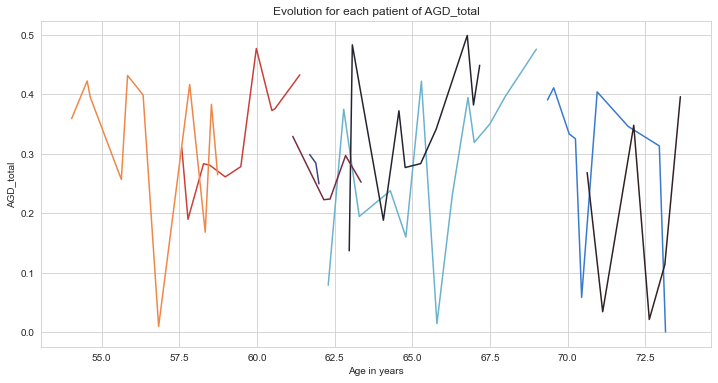

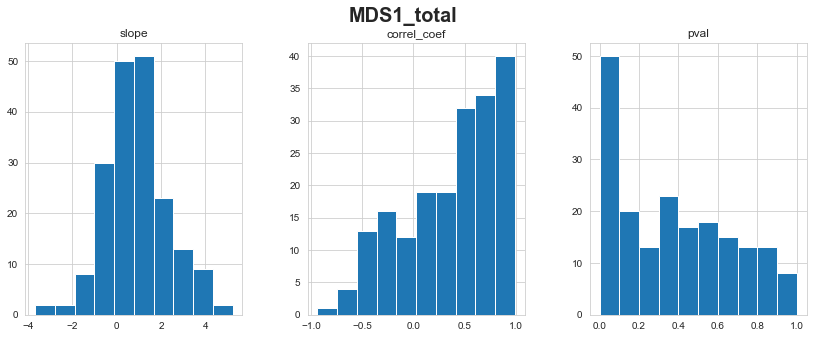

MDS1_total: linear correlation coefficient with time = 0.36 ± 0.45


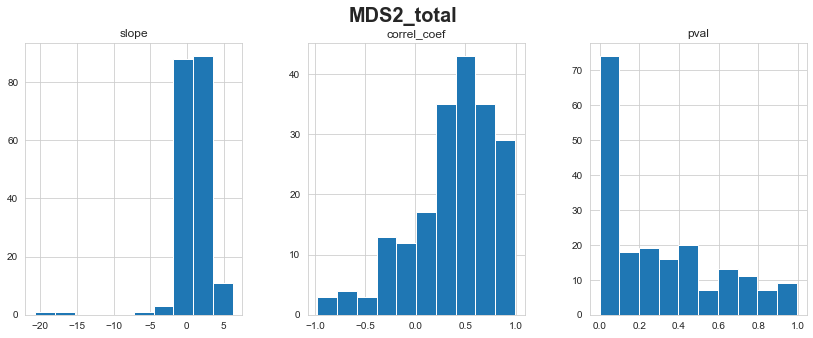

MDS2_total: linear correlation coefficient with time = 0.37 ± 0.42


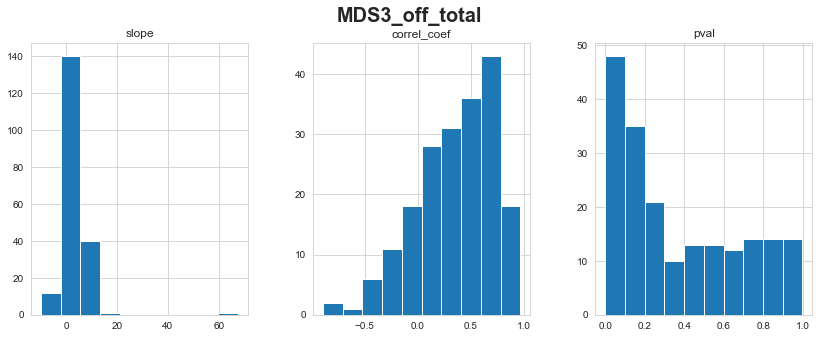

MDS3_off_total: linear correlation coefficient with time = 0.35 ± 0.37


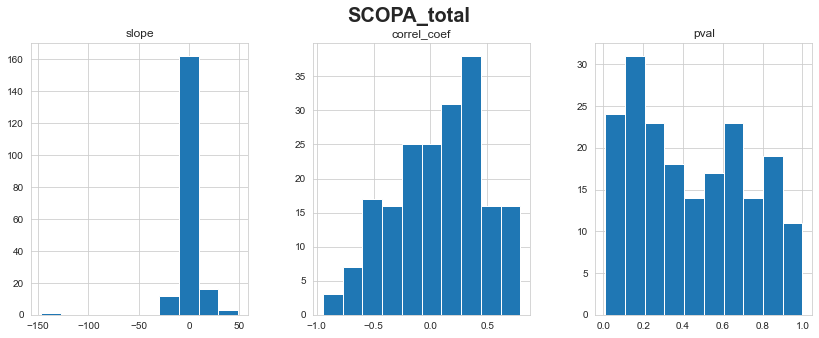

SCOPA_total: linear correlation coefficient with time = 0.08 ± 0.40


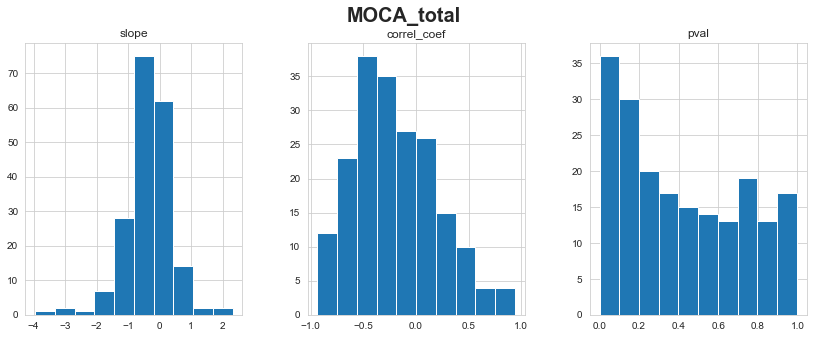

MOCA_total: linear correlation coefficient with time = -0.20 ± 0.39


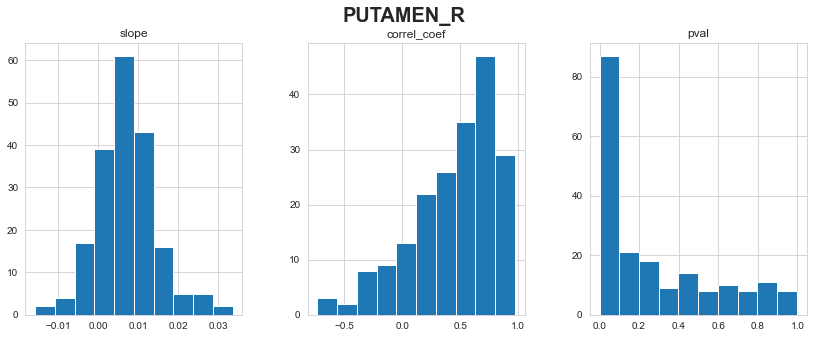

PUTAMEN_R: linear correlation coefficient with time = 0.44 ± 0.37


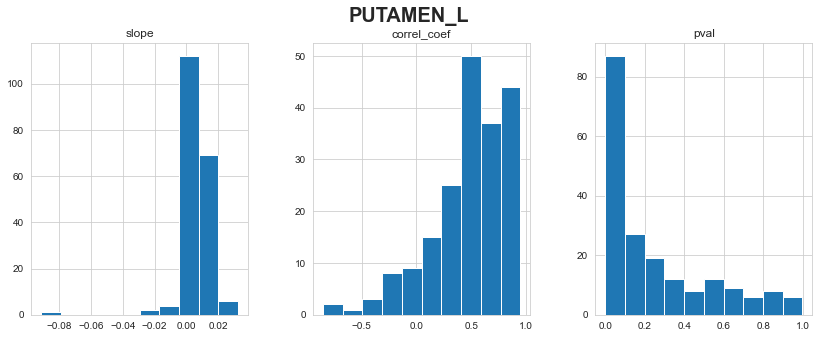

PUTAMEN_L: linear correlation coefficient with time = 0.48 ± 0.35


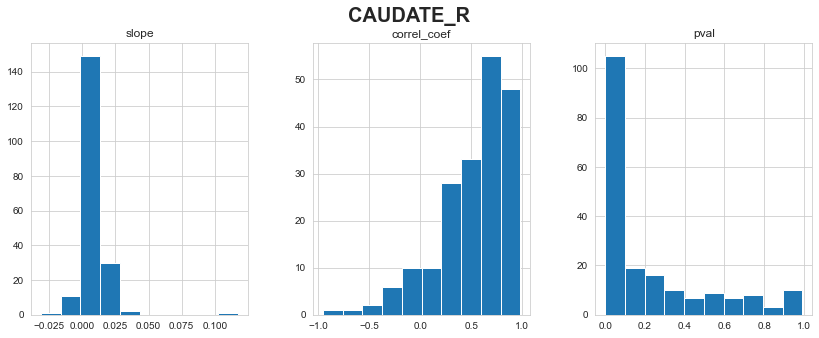

CAUDATE_R: linear correlation coefficient with time = 0.53 ± 0.35


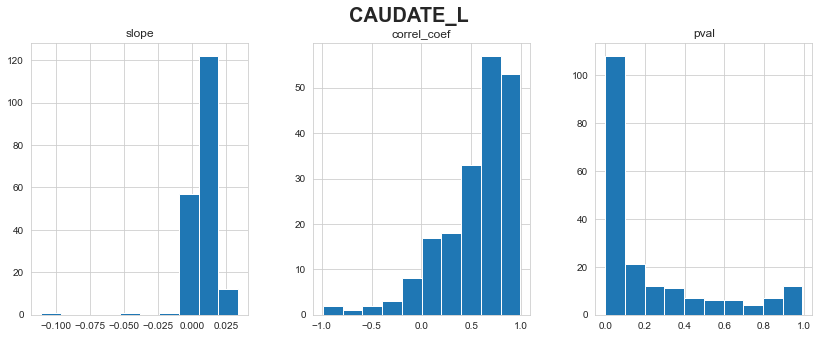

CAUDATE_L: linear correlation coefficient with time = 0.54 ± 0.36


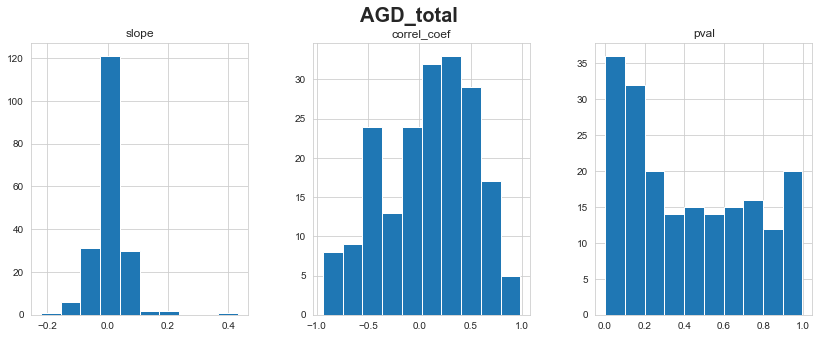

AGD_total: linear correlation coefficient with time = 0.09 ± 0.44


In [10]:
plot_individuals(df, "AGD_total", sublist = df.index.unique('ID')[:8])
plt.show()

for ft_name, s in df.items():

    ilr_ft = individual_linear_regression_against_time(df, ft_name)

    ax = ilr_ft[['slope','correl_coef', 'pval']].hist(figsize=(14,5), layout=(1,3))
    plt.gcf().suptitle(ft_name+'\n', fontweight='bold', fontsize=20)
    plt.show()

    print(f"{ft_name}: linear correlation coefficient with time = "
          f"{ilr_ft['correl_coef'].mean():.2f} ± {ilr_ft['correl_coef'].std():.2f}")


<span style='color: #a13203; font-weight: 600;'>💬 Question 8 💬</span> __What do you conclude about AGD_total progression? Should we consider it for longitudinal modelling?__

Your answer: ...

<span style='color: #a13203; font-weight: 600;'>💬 Question 9 💬</span> __Now that you know the progression of all the features, can you normalize them all now? If not what is the issue and which features are concerned?__

Your answer: ...

<span style='color: #a13203; font-weight: 600;'>💬 Question 10 💬</span> __Run the code below to split the data into a training and testing set.__

In [11]:
##CREATE TRAINING AND TESTING SETS
patient_stop = 'GS-100'  # 50%
patient_start = 'GS-101' # 50%

df_train = df.loc[:patient_stop].copy()
df_test = df.loc[patient_start:].copy()
df_to_pred = df_vis.loc[patient_start:].copy()

<span style='color: #a13203; font-weight: 600;'>💬 Question 11 💬</span> __Normalize the data using the function below and making sure that you have increasing data at the end.__

In [12]:
def normalize(df, feat, max_, min_, increase = True):
    df_study = df[feat].copy()
    df_study = (df_study - min_) / (max_ - min_)
    if not increase :
        df_study = 1 - df_study
    return df_study

In [13]:
# bounded scores
scores = {
    "MDS1_total": (52, 0, True), # max, min, increase?
    "MDS2_total": (52, 0, True),
    "MDS3_off_total": (132, 0, True),
    "SCOPA_total": (72, 0, True),
    "MOCA_total": (30, 0, False),
    #"AGD_total": #No need we will not use it...
}

for score_name, normalize_args in scores.items():
    df_train.loc[:, score_name] = normalize(df_train, score_name, *normalize_args)
    df_test.loc[:, score_name] = normalize(df_test, score_name, *normalize_args)
    df_to_pred.loc[:, score_name] = normalize(df_to_pred, score_name, *normalize_args)

# imagery #No need we will not use it...
#for var_name in ['PUTAMEN_R', 'PUTAMEN_L', 'CAUDATE_R', 'CAUDATE_L']:
#    normalize_args = (df_train[var_name].max(), df_train[var_name].min(), True)  # (all features are increasing)
#
#    df_train.loc[:, var_name] = normalize(df_train, var_name, *normalize_args)
#    df_test.loc[:, var_name] = normalize(df_test, var_name, *normalize_args)
#    df_to_pred.loc[:, var_name] = normalize(df_to_pred, var_name, *normalize_args)

In [14]:
#Save data
#df_train.to_csv(data_path("train_leaspy_ready.csv"))
#df_test.to_csv(data_path("test_leaspy_ready.csv"))
#df_to_pred.to_csv(data_path("to_pred_leaspy_ready.csv"))

In [15]:
#Bypass Data Cleaning - Get data
#df_train = pd.read_csv(data_path("train_leaspy_ready.csv"))
#df_test = pd.read_csv(data_path("test_leaspy_ready.csv"))
#df_to_pred = pd.read_csv(data_path("to_pred_leaspy_ready.csv"))

### I.2. Train your model

<span style='color: #015e75; font-weight: 600;'>ℹ️ Information ℹ️</span> Be careful you have only an __hour and half__ and running a leaspy model on ten features can take a lot of time... We advise you to start by univariate model ...

<span style='color: #a13203; font-weight: 600;'>💬 Question 12 💬</span> __Complete the code below to select the columns you want to use to train your leaspy model.__

In [16]:
cols = ["MDS3_off_total", "MDS2_total"]

data_train = Data.from_dataframe(df_train[cols])
data_test = Data.from_dataframe(df_test[cols])

<span style='color: #a13203; font-weight: 600;'>💬 Question 13 💬</span> __Complete the code below to set the parameters you want for your model.__

In [17]:
leaspy_model = "logistic"
nb_source = 1
algo_settings = AlgorithmSettings('mcmc_saem',
                                  n_iter=1000,           # n_iter defines the number of iterations
                                  seed=0)                # Make the calibration deterministic for reproducibility

algo_settings.set_logs(path='logs',
    console_print_periodicity=None,  # If = N, it display logs in the console/terminal every N iterations
    overwrite_logs_folder=True       # Default behaviour raise an error if the folder already exists.
)

##FIT
leaspy = Leaspy(leaspy_model, source_dimension=nb_source)
leaspy.fit(data_train, settings=algo_settings)

#leaspy = Leaspy.load('./outputs/model_parameters.json')

/opt/anaconda3/lib/python3.8/site-packages/leaspy/io/settings/outputs_settings.py:94: UserWarning: The logs path you provided (/Users/juliette.ortholand/ownCloud/juliette.ortholand/these/winter school/disease-course-mapping-solutions/solutions/TP3_advanced_leaspy/logs) does not exist. Needed paths will be created (and their parents if needed).
  warnings.warn(f"The logs path you provided ({settings['path']}) does not exist. "


 ==> Setting seed to 0
|##################################################|   1000/1000 iterations
Fit with `mcmc_saem` took: 1m 11s
The standard deviation of the noise at the end of the fit is:
MDS3_off_total: 6.57%
MDS2_total: 6.50%


<span style='color: #a13203; font-weight: 600;'>💬 Question 14 💬</span> __Evaluate that your model learned well and then save it.__

In [18]:
# Check the logs, the noise std, coherence of model parameters, ...

if not os.path.exists("outputs/"):
    os.makedirs("outputs/")

leaspy.save('./outputs/model_parameters.json')

print(leaspy.model.parameters)

from IPython.display import IFrame
IFrame('./logs/plots/convergence_1.pdf', width=990, height=670)

{'g': tensor([1.0923, 1.8324]), 'v0': tensor([ -5.0628, -10.1843]), 'betas': tensor([[0.0783]]), 'tau_mean': tensor(70.0796), 'tau_std': tensor(13.3633), 'xi_mean': tensor(0.), 'xi_std': tensor(0.7781), 'sources_mean': tensor(0.), 'sources_std': tensor(1.), 'noise_std': tensor([0.0657, 0.0650])}


### I.3. Test your model

<span style='color: #a13203; font-weight: 600;'>💬 Question 15 💬</span> __Complete the code below to make the predictions.__

In [19]:
##SET PARAMETERS
settings_personalization = AlgorithmSettings('scipy_minimize', seed=0)

##PREDICTIONS
ip = leaspy.personalize(data_test, settings_personalization)
reconstruction = leaspy.estimate(df_to_pred.index, ip)
df_pred = reconstruction.add_suffix('_model1')
df_pred.head()

 ==> Setting seed to 0
|##################################################|   100/100 subjects
Personalize with `scipy_minimize` took: 2s
The standard deviation of the noise at the end of the personalize is:
MDS3_off_total: 6.19%
MDS2_total: 7.37%


,,MDS3_off_total_model1,MDS2_total_model1
ID,TIME,,
GS-101,72.52,0.3005,0.2267
GS-102,78.57,0.3587,0.2408
GS-103,64.16,0.1513,0.1416
GS-104,74.09,0.1959,0.06328
GS-105,63.59,0.1617,0.1121


<span style='color: #a13203; font-weight: 600;'>💬 Question 16 💬</span> __Display results of your prediction against real values and the mean absolute error.__

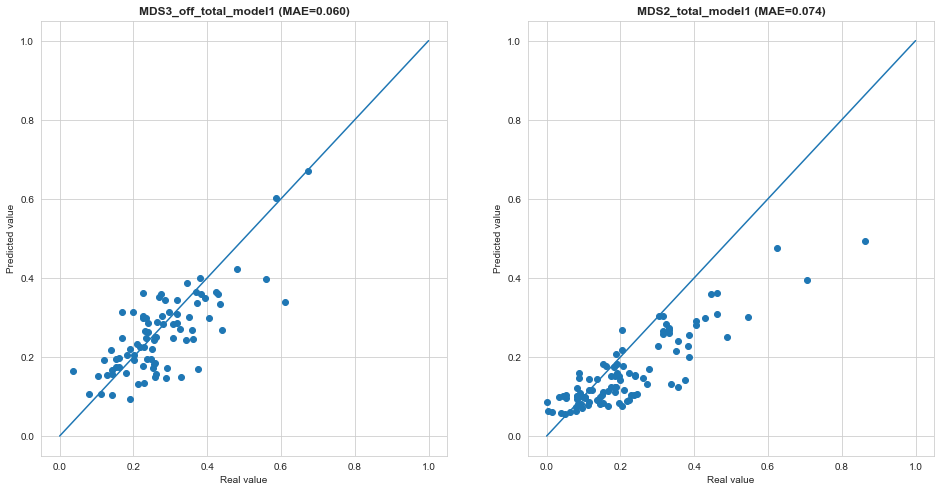

In [20]:
def plot_compare_values(s_model: pd.Series, s_real: pd.Series, *, ax):
    mae = (s_model - s_real).abs().mean()
    ax.set_title(f"{s_model.name} (MAE={mae:.3f})", fontweight='bold')
    ax.scatter(s_real, s_model)
    ax.plot([0,1],[0,1])  # Bisect
    ax.set_xlabel("Real value")
    ax.set_ylabel("Predicted value")

_, axs = plt.subplots(1, len(cols), figsize=(16, 8))
for s, ax in zip(cols, axs):
    plot_compare_values(df_pred[s+'_model1'], df_to_pred[s], ax=ax)

<span style='color: #015e75; font-weight: 600;'>ℹ️ Information ℹ️</span> Note that an average good error is about 5% of absolute error for MDS3_off_total.

# Part II: Binary Scores

In this section we showcase how Leaspy is able to handle binary observations.
By that we mean discrete features that can take either the value $0$ or $1$.
Such features are often encountered in clinical records for they can account for "symptom status": we either observe or do not observe a given symptom at a given visit.

## II.1. Data Loading and Inspection

Start by running the following cell to load a dataset of binary observations.

In [21]:
# load the dataframe from the data/ folder
binary_df = pd.read_csv(data_path("binary_data.csv"))

# set the leaspy-compatible multi-indexing
binary_df = binary_df.set_index(['ID', 'TIME'], verify_integrity=True).sort_index()
data_binary = Data.from_dataframe(binary_df)

<span style='color: #a13203; font-weight: 600;'>💬 Question 17 💬</span> __Inspect the dataframe to understand how the data behaves (*e.g* plot the observations for a few patients, look at the distribution of observations).__

Symptom 1  Symptom 2  Symptom 3
1          1          1            727
0          0          0            280
1          1          0            221
0          0          1            131
1          0          0             63
                      1             58
0          1          1             22
                      0             16
dtype: int64

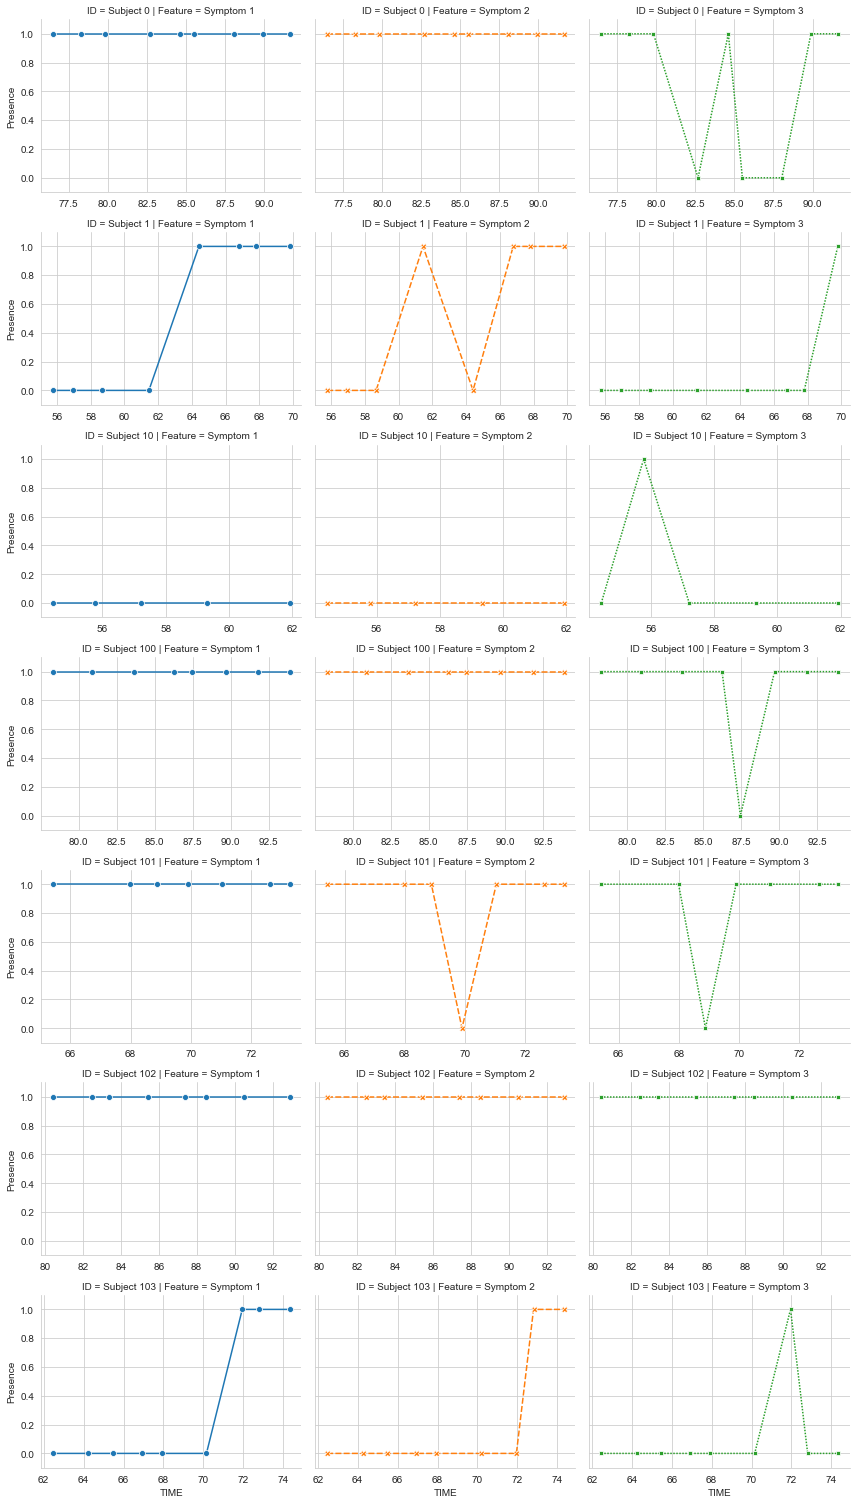

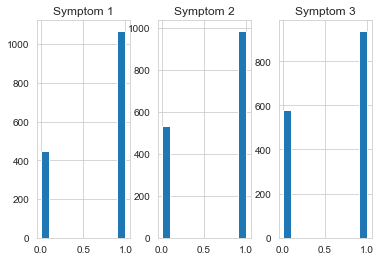

In [22]:
# plot a few subject observations

first_subjs = binary_df.loc[binary_df.index.unique('ID')[:7]]

sns.relplot(
    data=first_subjs.rename_axis(columns='Feature').stack().rename('Presence').reset_index(),
    row='ID', col='Feature', hue='Feature', style='Feature',
    x='TIME', y='Presence', markers=True,
    kind='line', height=3, aspect=4/3, legend=False,
    facet_kws=dict(sharex=False, sharey=True, ylim=(-0.1,1.1), legend_out=True)
)

binary_df.hist(layout=(1,3))

binary_df.value_counts()

The observations are noisy, and it is hard to relate the symptom together or really understand the disease progression.
Such noisy observations (with multiple *on-off* transitions) are indeed frequent in diseases such as Parkinson's disease, where motor symptoms can appear and disappear within a few hours.

<span style='color: #a13203; font-weight: 600;'>💬 Question 18 💬</span> __In the spirit of question 7, study the relationship between the observed symptoms and time. The question that we would like to answer is basically *“Is a given symptom more likely to be observed as age increase?”*__

You can reuse for instance reuse the function `individual_linear_regression_against_time` provided before.
Even though linear regression might not be the most suited modelling tool, it can give us a first sanity check as to whether symptom occurrences are increasing with time.

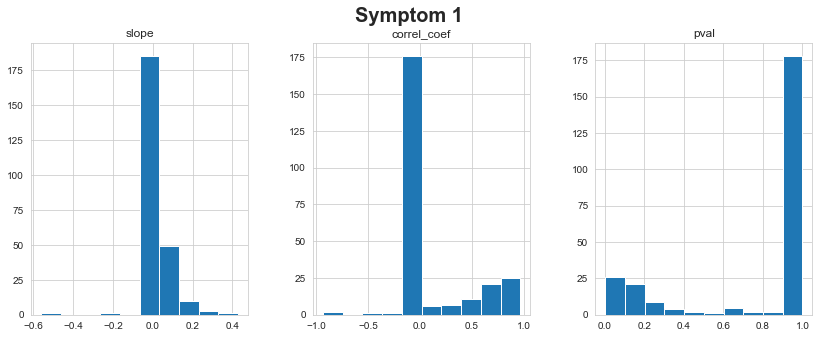

Symptom 1: linear correlation coefficient with time = 0.16 ± 0.33


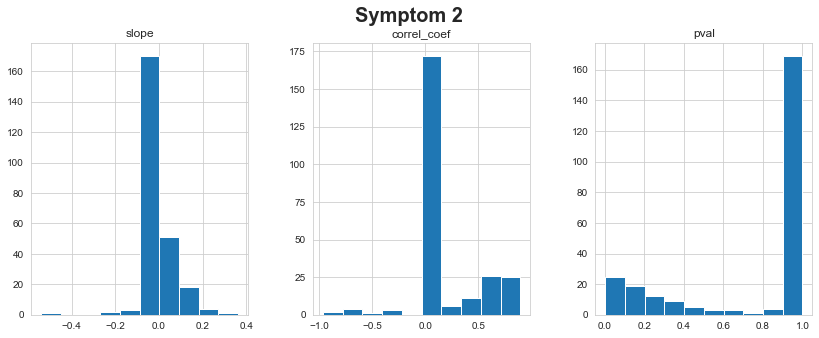

Symptom 2: linear correlation coefficient with time = 0.15 ± 0.34


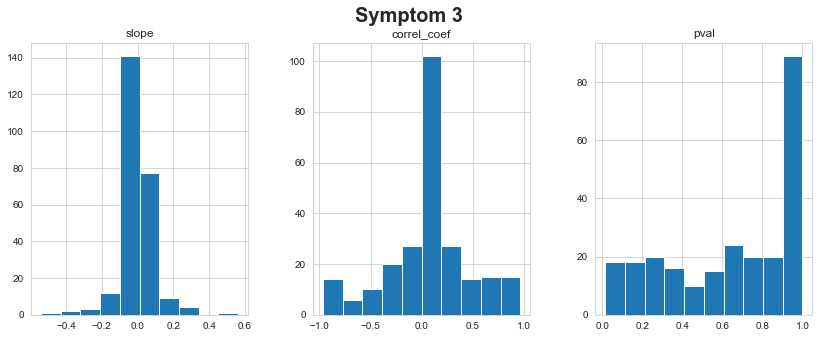

Symptom 3: linear correlation coefficient with time = 0.05 ± 0.41


In [23]:
for ft_name, s in binary_df.items():

    ilr_ft = individual_linear_regression_against_time(binary_df, ft_name)

    ax = ilr_ft[['slope','correl_coef', 'pval']].hist(figsize=(14,5), layout=(1,3))
    plt.gcf().suptitle(ft_name+'\n', fontweight='bold', fontsize=20)
    plt.show()

    print(f"{ft_name}: linear correlation coefficient with time = "
          f"{ilr_ft['correl_coef'].mean():.2f} ± {ilr_ft['correl_coef'].std():.2f}")

## II.2. Use a Standard Leaspy model to analyse the data

Now that we have determined that observations are “increasing” with time, and because this data is naturally bounded between $0$ and $1$, it is tempting to use the tools provided by Leaspy to model those symptoms occurrences.

<span style='color: #a13203; font-weight: 600;'>💬 Question 19 💬</span> __Run the following two cells to calibrate a standard Leaspy model on this binary data and plot the average trajectory as modelled.__

In [24]:
leaspy_model = "logistic"
nb_source = 1  # let us fix the number of sources to 1 in this example

algo_settings = AlgorithmSettings('mcmc_saem',
                                  n_iter=1500,           # n_iter defines the number of iterations
                                  seed=0)                # Make the calibration deterministic for reproducibility

# calibrate the model
leaspy = Leaspy(leaspy_model, source_dimension=nb_source)
leaspy.fit(data_binary, settings=algo_settings)

 ==> Setting seed to 0
|##################################################|   1500/1500 iterations
Fit with `mcmc_saem` took: 33s
The standard deviation of the noise at the end of the fit is:
Symptom 1: 14.49%
Symptom 2: 18.18%
Symptom 3: 41.39%


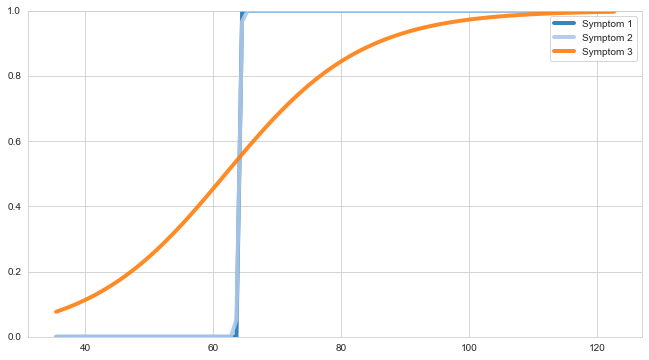

In [25]:
plotter = Plotter()
plotter.plot_mean_trajectory(leaspy.model)

Observe that the calibration converged to an average model where symptoms 1 and 2 are expected to appear at the same time and almost immediately, while the third symptom has a more progressive rate of appearance.
Notice how steep is the transition from the *off* to *on* status for both symptom 1 and 2.
This might be a hint that a numerical artefact happened during calibration and that this above average model does not really reflect the true data.

We will investigate this in the following question. One thing that we can easily check is whether Symptom 1 and 2 really occur at the same age among patients.

<span style='color: #a13203; font-weight: 600;'>💬 Question 20 💬</span> __Compute the age at which symptom 1 and symptom 2 are first observed for each subjects, and check whether those ages are significantly different or not for each subject.__

Ttest_1sampResult(statistic=-3.1773833578465625, pvalue=0.0017230482137870525)


count       200
mean    -0.3723
std       1.657
min      -6.732
50%           0
max       8.158
dtype: float64

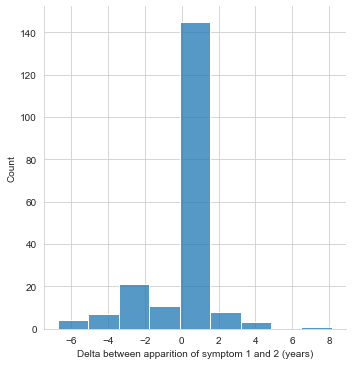

In [26]:
# compute the appearance time of both symptoms
symptom_1_appearance_time = binary_df.loc[binary_df["Symptom 1"] == 1].reset_index().groupby('ID')[['TIME']].min()
symptom_2_appearance_time = binary_df.loc[binary_df["Symptom 2"] == 1].reset_index().groupby('ID')[['TIME']].min()

# compute the delta between appearance of the first and second symptom
symptom_delta = pd.merge(symptom_1_appearance_time, symptom_2_appearance_time, on='ID',suffixes=('_symptom_1', '_symptom_2'))
symptom_delta = symptom_delta['TIME_symptom_1'] - symptom_delta['TIME_symptom_2']

sns.displot(symptom_delta)
plt.xlabel("Delta between apparition of symptom 1 and 2 (years)");

# check whether this delta between onset of symptom 1 and 2 is significantly different from 0
print(stats.ttest_1samp(symptom_delta, popmean=0.))
symptom_delta.describe([])

<span style='color: #a13203; font-weight: 600;'>💬 Question 21 💬</span> __Can you provide an intuitive explanation as to why the leaspy model is not to model such binary data?__

A standard Leaspy model considers the features as continuous variables.
Observations are indeed modelled as points from a geodesic lying on a manifold observed with an extra noise term. We impose a Gaussian prior on this noise term. This noise structure suits the setting of continuous variables and provides us with optimization objectives that we can follow to calibrate the model: we basically try to minimize the $l_2$ norm of the reconstruction error (~ the noise standard deviation), it is unsuited to binary observations.

This is similar to classification learning-settings where a different loss function (such as a cross-entropy loss) has to be used to calibrate a binary predictor, because a $l_2$ distance does not make sense to quantify a classification error.

## II.3. Use a more adapted Leaspy model to analyse the data

The previous example has shown that the standard leaspy model is not well suited to binary features.
Fortunately we also provide tools to analyse such data, namely *Bernoulli* structure.
When the already introduced Leaspy model (for continuous data, *i.e.* with a *Gaussian* noise structure under the hood) can be seen as an extension of the standard linear regression through a non-linear mixed-effect model, a Leaspy model with a *Bernoulli* noise-structure extends the standard *logistic regression* framework with a non-linear mixed effect framework.

<span style='color: #a13203; font-weight: 600;'>💬 Question 22 💬</span> __Run the following two cells to calibrate a leaspy model with a *Bernoulli* noise structure.__

Notice how we introduce the `noise_model` parameter when we instantiate the model.

In [27]:
leaspy_model = "logistic"
nb_source = 1
algo_settings = AlgorithmSettings('mcmc_saem',
                                  n_iter=1500,           # n_iter defines the number of iterations
                                  seed=0)                # Make the calibration deterministic for reproducibility

leaspy_bernoulli = Leaspy(leaspy_model, noise_model="bernoulli", source_dimension=nb_source)
leaspy_bernoulli.fit(data_binary, settings=algo_settings)

 ==> Setting seed to 0
|##################################################|   1500/1500 iterations
Fit with `mcmc_saem` took: 32s
The standard deviation of the noise at the end of the fit is:
30.23%


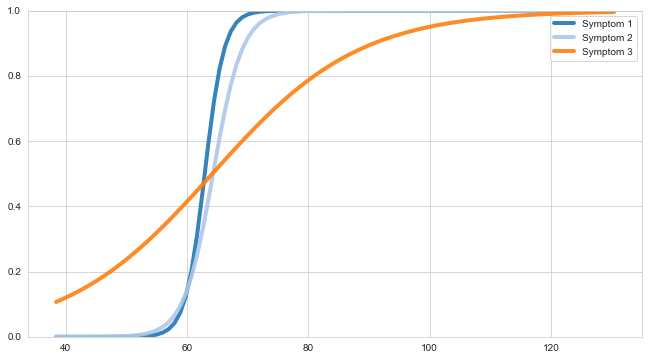

In [28]:
plotter.plot_mean_trajectory(leaspy_bernoulli.model)

The model looks much better, and the slight (significative) delta observed in the raw data (see *question xx*) can now be observed!

The model is also more interpretable, since it inherently model binary data.

<span style='color: #a13203; font-weight: 600;'>💬 Question 23 💬</span> __Try to interpret this average model by relating those logistic curves to the binary variables. What do the asymptotes and the transient zone represent and tell us about the disease progression?__

The horizontal asymptotes are age ranges where the symptoms are mainly either zero or one, without much switches between visits. The transient zone is the zone where status switches occur, and are hints that the patient might be heading toward a “always on” status for a given symptom. Symptoms 1 and 2 are relatively abrupt symptoms, while Symptom 3 is more likely to be switching between both “on” and “off” status for a longer period of time.

<span style='color: #a13203; font-weight: 600;'>💬 Question 24 💬</span> __Compare the individual parameters obtained either with the standard model or the Bernoulli model. Which model better respects the assumptions made on $\tau$ and $\xi$?__

 ==> Setting seed to 0
|##################################################|   250/250 subjects
Personalize with `scipy_minimize` took: 2s
The standard deviation of the noise at the end of the personalize is:
Symptom 1: 18.10%
Symptom 2: 22.63%
Symptom 3: 40.82%
 ==> Setting seed to 0
|##################################################|   250/250 subjects
Personalize with `scipy_minimize` took: 7s
The standard deviation of the noise at the end of the personalize is:
Symptom 1: 23.23%
Symptom 2: 25.01%
Symptom 3: 38.80%


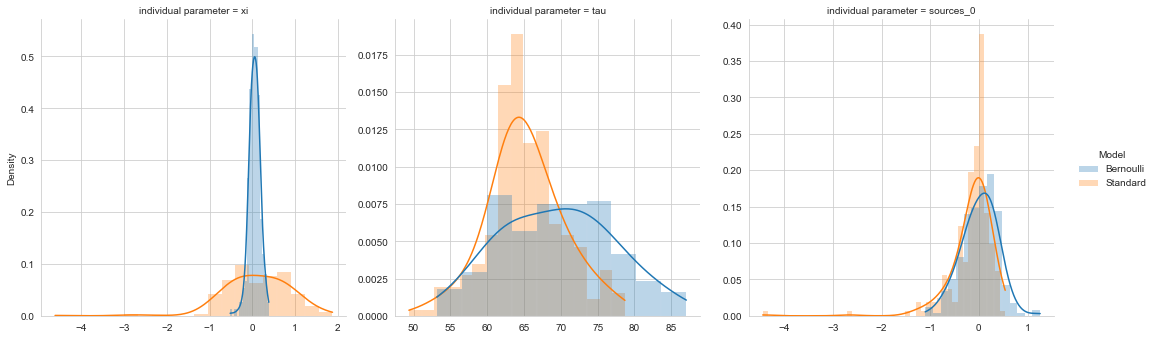

In [29]:
personalize_settings = AlgorithmSettings('scipy_minimize', seed=0)

ip_bernoulli = leaspy_bernoulli.personalize(data_binary, settings=personalize_settings).to_dataframe()
ip_standard = leaspy.personalize(data_binary, settings=personalize_settings).to_dataframe()

joined_ip = pd.concat({
    'Bernoulli': ip_bernoulli,
    'Standard': ip_standard
}, names=['Model']).rename_axis(columns='individual parameter')

sns.displot(
    data=joined_ip.stack().rename('value').reset_index(),
    x='value',
    col='individual parameter',
    hue='Model',
    kind='hist', kde=True, kde_kws=dict(bw_adjust=1.5, cut=0),
    common_bins=False, common_norm=True,
    alpha=.3, stat='density',
    facet_kws=dict(sharex=False, sharey=False)
).set_xlabels('');

# Part III: Univariate vs Multivariate

Now that you have a multivariate model that works, let's compare the multivariate and univariate model. For that you will compare a multivariate model with MDS3 and MDS2 with two univariate model MDS2 and MDS3 separately.

<span style='color: #a13203; font-weight: 600;'>💬 Question 25 💬</span> __Fit 3 models, one multivariate and two univariate with MDS2 and MDS3.__

In [30]:
leaspy_model_u = 'univariate_logistic'
leaspy_model = "logistic"
algo_settings = AlgorithmSettings('mcmc_saem',
                                  n_iter=1500,           # n_iter defines the number of iterations
                                  seed=0)                # Make the calibration deterministic for reproducibility

#algo_settings.set_logs(path=...)

#With MDS2 and MDS3
data_train23 = Data.from_dataframe(df_train[["MDS3_off_total", "MDS2_total"]])
data_test23 = Data.from_dataframe(df_test[["MDS3_off_total", "MDS2_total"]])

leaspy23 = Leaspy(leaspy_model, source_dimension=1)
leaspy23.fit(data_train23, settings=algo_settings)
leaspy23.save('./outputs/model_parameters_23.json')

#With MDS3
data_train3 = Data.from_dataframe(df_train[["MDS3_off_total"]])
data_test3 = Data.from_dataframe(df_test[["MDS3_off_total"]])

leaspy3 = Leaspy(leaspy_model_u)
leaspy3.fit(data_train3, settings=algo_settings)
leaspy3.save('./outputs/model_parameters_3.json')

#With MDS2
data_train2 = Data.from_dataframe(df_train[["MDS2_total"]])
data_test2 = Data.from_dataframe(df_test[["MDS2_total"]])

leaspy2 = Leaspy(leaspy_model_u)
leaspy2.fit(data_train2, settings=algo_settings)
leaspy2.save('./outputs/model_parameters_2.json')


 ==> Setting seed to 0
|##################################################|   1500/1500 iterations
Fit with `mcmc_saem` took: 24s
The standard deviation of the noise at the end of the fit is:
MDS3_off_total: 6.69%
MDS2_total: 6.47%
 ==> Setting seed to 0
|##################################################|   1500/1500 iterations
Fit with `mcmc_saem` took: 4s
The standard deviation of the noise at the end of the fit is:
6.65%
 ==> Setting seed to 0
|##################################################|   1500/1500 iterations
Fit with `mcmc_saem` took: 5s
The standard deviation of the noise at the end of the fit is:
5.22%


<span style='color: #a13203; font-weight: 600;'>💬 Question 26 💬</span> __Make the predictions for each model.__

In [31]:
##SET PARAMETERS
settings_personalization = AlgorithmSettings('scipy_minimize', seed=0)

def get_df_predictions(leaspy_obj: Leaspy,
                       data_test: Data, *,
                       model_suffix: str) -> pd.DataFrame:
    """Personalize leaspy model and predict values at given timepoints (cf. Question 15)."""

    ip = leaspy_obj.personalize(data_test, settings_personalization)
    reconstruction = leaspy_obj.estimate(df_to_pred.index, ip)
    return reconstruction.add_suffix(model_suffix)

##PREDICTIONS MDS2&3 from multivariate model
df_pred23 = get_df_predictions(leaspy23, data_test23, model_suffix='_model_m')

##PREDICTIONS MDS2 from univariate model
df_pred2 = get_df_predictions(leaspy2, data_test2, model_suffix='_model_u')

##PREDICTIONS MDS3 from univariate model
df_pred3 = get_df_predictions(leaspy3, data_test3, model_suffix='_model_u')

#CONCATENATE PREDICTIONS
df_pred_mu = pd.concat([df_pred23, df_pred3, df_pred2], axis = 1)

 ==> Setting seed to 0
|##################################################|   100/100 subjects
Personalize with `scipy_minimize` took: 1s
The standard deviation of the noise at the end of the personalize is:
MDS3_off_total: 6.98%
MDS2_total: 7.36%
 ==> Setting seed to 0
|##################################################|   100/100 subjects
Personalize with `scipy_minimize` took: 2s
The standard deviation of the noise at the end of the personalize is:
5.09%
 ==> Setting seed to 0
|##################################################|   100/100 subjects
Personalize with `scipy_minimize` took: 1s
The standard deviation of the noise at the end of the personalize is:
6.75%


<span style='color: #a13203; font-weight: 600;'>💬 Question 27 💬</span> __Display results of predictions against real values and the mean absolute error.__

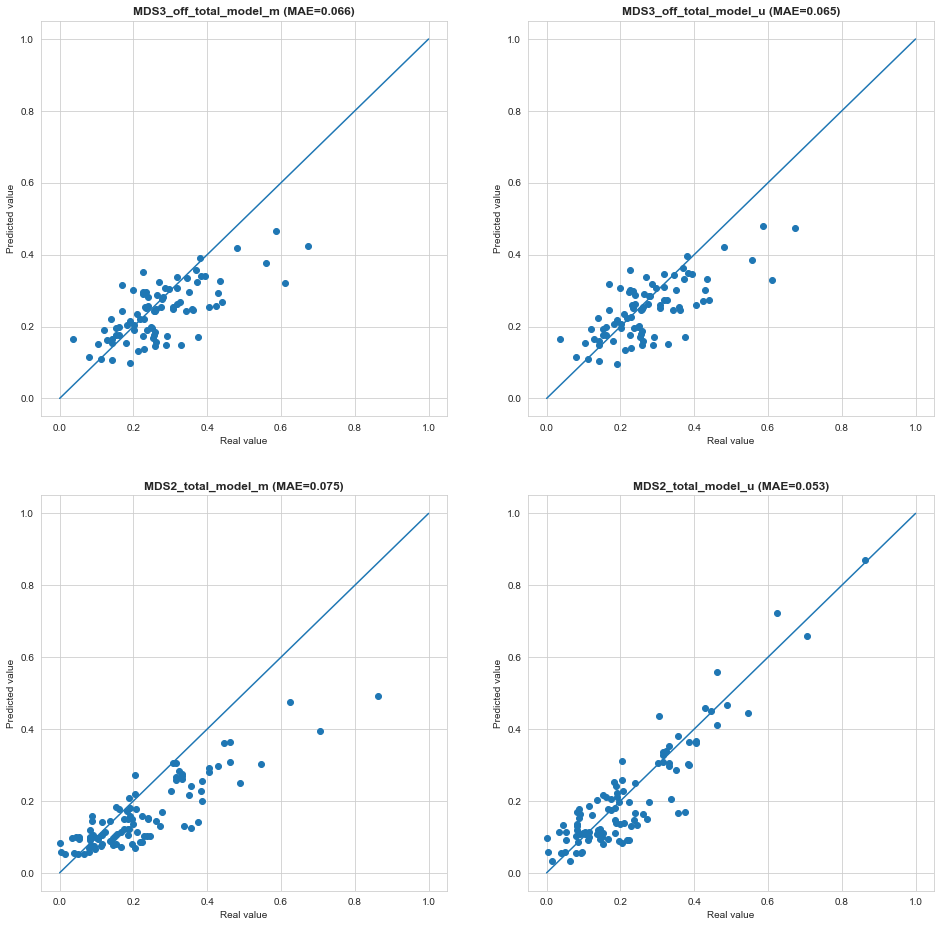

In [32]:
cols_pred = ['MDS3_off_total_model_m', 'MDS3_off_total_model_u', 'MDS2_total_model_m', 'MDS2_total_model_u']
cols_real = ['MDS3_off_total', 'MDS3_off_total','MDS2_total', 'MDS2_total']

_, axs = plt.subplots(2, 2, figsize=(16, 16))
for col_pred, col_real, ax in zip(cols_pred, cols_real, axs.flatten()):
    plot_compare_values(df_pred_mu[col_pred], df_to_pred[col_real], ax=ax)

# Part IV: Get the best model as you can


If you have finished early, you can first fill the [Google form](https://docs.google.com/forms/d/e/1FAIpQLSfLF8v0q_tRxNcFfBylS_x-1PM1FoQM21OLwg4ILgGc8jLkUQ/viewform?usp=sf_link) to help us improve our workshop !
Then go back to part I and try to get the best results you can by changing the features selected, the data processing pipeline...